In [1]:
from gensim import corpora, models
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

/Users/Trent/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


Let's create some demo data.
<b>data_unformatted</b> is a dictionary where:
<ul><li><b>'action'</b> is a list of tokenized customer journies. </li>
<li><b>'duration'</b> is the amount of time associated with each event in the journey. More specifically, I'm thinking of it as the time between one event and the next within a journey.
</li></ul>

In [2]:
data_unformatted = {'journey':[['view_home_screen', 'search_Telemark_Skis',\
'view_results', 'click_first_result'], ['view_recommendations','click_Akira_Poster',\
'buy_item'],['view_home_screen', 'search_Telemark_Skis', 'view_results','click_fifth_result',\
'buy_item'], ['view_recommendtions','click_Christmas_Lights','view_recommendations',\
'click_Cell_Phone_Case','view_recommendations', 'click_VR_Headset']], 'duration':[[2,10,4,8],\
[68,45,10], [3,10,25,6], [20,6,12,8,16,10]]}

data_df = pd.DataFrame(data = data_unformatted, columns = ['journey', 'duration'])
data_df

,journey,duration
0,"[view_home_screen, search_Telemark_Skis, view_...","[2, 10, 4, 8]"
1,"[view_recommendations, click_Akira_Poster, buy...","[68, 45, 10]"
2,"[view_home_screen, search_Telemark_Skis, view_...","[3, 10, 25, 6]"
3,"[view_recommendtions, click_Christmas_Lights, ...","[20, 6, 12, 8, 16, 10]"


Now we want to convert journey events into transitions. I do this simply because my transition results were more interesting the last time I did this.

In [3]:
def doc_combine(words_list):
    #INPUT: list of words 
    #OUTPUT: list of word transitions
    zip_list = zip(words_list, words_list[1:])
    result_list =[val[0] + '->' + val[1] for val in zip_list]
    return result_list

def time_combine(times_list):
    #INPUT: list of times
    #OUTPUT: list of time combinations
    zip_list = zip(times_list, times_list[1:])
    result_list = [val[0]+val[1] for val in zip_list]
    return result_list


Now lets combine times so that we have the total time it took to perform both events in the transition.

In [4]:
for row in range(data_df.shape[0]):
    data_df.loc[row, 'journey'] = doc_combine(data_df.loc[row,'journey'])
    data_df.loc[row, 'duration'] = time_combine(data_df.loc[row, 'duration'])

#Let's verify that this worked.
print data_df.iloc[0,0], '\n\n\n', data_df.iloc[0,1]

['view_home_screen->search_Telemark_Skis', 'search_Telemark_Skis->view_results', 'view_results->click_first_result'] 


[12, 14, 12]


<h3> Integrating Time into LDA</h3><br>
There are a dozen ways we can integrate time into our LDA model. The way I'm going to demo is a super oversimplication: I'm going to split our journey transitions into <b>"browsing"</b> transitions and <b>"seeking"</b> transition. 

Browsing will be transitions that take less time. 
Seeking will be transitions that take more time. 

So first, let's look at a distribution of the transitions to see if they're skewed or normal. This will tell us if we should split on the median or the mean.

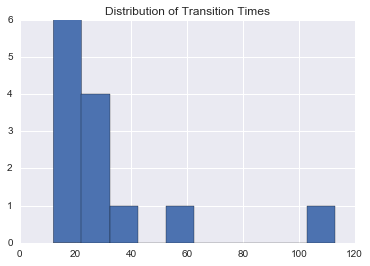

In [5]:
#Get all the times
bag_of_times = []
for row in data_df['duration']:
    for time in row:
        bag_of_times.append(time)

plt.hist(bag_of_times)
plt.title('Distribution of Transition Times')

Our data definitely looks skewed. So let's go with the median as a splitting point to determine which transitions will be labeled "browsing" versus "seeking." 

In [6]:
print np.median(bag_of_times)

24.0


One other way I could split the browsers versus the seekers is by looking at the times associated with transitions in customer journeys that include purchases versus customer journeys that don't include purchases. This is a bit daft because it doesn't take into account users who are trying to find something useful but don't. Nevertheless, it could tell us a bit about differences between buyers and surfers.

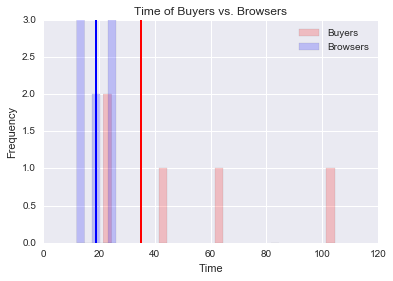

In [7]:
buy_times = []
browse_times = []

for idx, row in enumerate(list(data_df['duration'])):
    if 'buy_item' in data_unformatted['journey'][idx]:
        for time in row:
            buy_times.append(time)
    else:
        for time in row:
            browse_times.append(time)
            
buyers = plt.hist(buy_times, bins=5,  facecolor='red', rwidth = 0.15, alpha = 0.2,\
                  label = 'Buyers')
browsers = plt.hist(browse_times, bins=5, facecolor='blue', rwidth = 1, alpha = 0.2,\
                   label = 'Browsers')
plt.axvline(x = np.median(buy_times), linewidth = 2, color = 'red')
plt.axvline(x = np.median(browse_times), linewidth = 2, color = 'blue')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Time of Buyers vs. Browsers')
plt.legend()

From this we can see that buyers are spending more time than none buyers. Because I created this data to reflect this, this comes as no surprise. Let's get back to the task at hand, though.

Let's make a column in data_df to reflect whether the mean of the times involved in a journey is above or below the median amount of time (<b>24 sec</b>).

In [8]:
data_df['gt_median'] = [np.mean(data_df.loc[row, 'duration']) > 24 for row in\
                        range(data_df.shape[0])]
data_df

,journey,duration,gt_median
0,"[view_home_screen->search_Telemark_Skis, searc...","[12, 14, 12]",False
1,"[view_recommendations->click_Akira_Poster, cli...","[113, 55]",True
2,"[view_home_screen->search_Telemark_Skis, searc...","[13, 35, 31]",True
3,"[view_recommendtions->click_Christmas_Lights, ...","[26, 18, 20, 24, 26]",False


In [9]:
data_gtm = data_df[data_df['gt_median'] == True]
data_ltm = data_df[data_df['gt_median'] != True]

print data_gtm, '\n\n', data_ltm

                                             journey      duration gt_median
1  [view_recommendations->click_Akira_Poster, cli...     [113, 55]      True
2  [view_home_screen->search_Telemark_Skis, searc...  [13, 35, 31]      True 

                                             journey              duration  \
0  [view_home_screen->search_Telemark_Skis, searc...          [12, 14, 12]   
3  [view_recommendtions->click_Christmas_Lights, ...  [26, 18, 20, 24, 26]   

  gt_median  
0     False  
3     False  


Now we can cluster on transitions within the data_gtm and data_ltm dataframes. This is how I would do it. Obviously, given the data, this isn't going to be very interesting.

In [10]:
def transitions_to_corpus(transitions):
    #INPUT: list of list of transitions
    #OUTPUT: Corpus in gensim format
    dictionary = corpora.Dictionary(transitions)
    corpus = [dictionary.doc2bow(text) for text in transitions]
    return corpus, dictionary

In [11]:
def gen_lda_model(corpus, dictionary, topic_qty = 2, word_qty=3):
    #INPUT: corpus and dictionary.
    #INPUT: topic_qty: how many topics to cluster
    #INPUT: word_qty: how many words to print
    #OUTPUT: lda model in gensim print format

    ldamodel = models.LdaMulticore(corpus, num_topics=topic_qty, id2word = dictionary,\
                                        passes=5, workers = 3)
    return ldamodel.show_topics(num_topics=topic_qty, num_words = word_qty)

Now we are going to generate the clusters from the two dataframes.

<h4>Clusters for data_gtm</h4>

In [12]:
corpus, dictionary = transitions_to_corpus(list(data_gtm['journey']))
gtm_model = gen_lda_model(corpus, dictionary)
print gtm_model

[(0, u'0.294*"view_recommendations->click_Akira_Poster" + 0.292*"click_Akira_Poster->buy_item" + 0.104*"view_home_screen->search_Telemark_Skis"'), (1, u'0.212*"click_fifth_result->buy_item" + 0.212*"search_Telemark_Skis->view_results" + 0.212*"view_results->click_fifth_result"')]


<h4>Clusters for data_ltm</h4>

In [13]:
corpus, dictionary = transitions_to_corpus(list(data_ltm['journey']))
ltm_model = gen_lda_model(corpus, dictionary)
print ltm_model

[(0, u'0.126*"view_recommendations->click_Cell_Phone_Case" + 0.126*"click_Christmas_Lights->view_recommendations" + 0.126*"view_recommendtions->click_Christmas_Lights"'), (1, u'0.129*"view_home_screen->search_Telemark_Skis" + 0.128*"search_Telemark_Skis->view_results" + 0.128*"view_results->click_first_result"')]


Let's do a quick visualizaiton for the gtm_model (greater than median model).
First I'm going to separate out the numbers and names from our clusters.

In [14]:
cluster_1 =  gtm_model[0][1].split(' + ')
cluster_1_nums = [float(val[:5]) for val in cluster_1]
cluster_1_names = [val[7:-1] for val in cluster_1]

cluster_2 = gtm_model[0][1].split(' + ')
cluster_2_nums = [float(val[:5]) for val in cluster_2]
cluster_2_names = [val[7:-1] for val in cluster_2]
 
print 'Cluster 1 values: ', cluster_1_nums,'\nCluster 1 names: ', cluster_1_names, '\n\n'
print 'Cluster 2 values: ', cluster_2_nums,'\nCluster 2 names: ', cluster_2_names

Cluster 1 values:  [0.294, 0.292, 0.104] 
Cluster 1 names:  [u'view_recommendations->click_Akira_Poster', u'click_Akira_Poster->buy_item', u'view_home_screen->search_Telemark_Skis'] 


Cluster 2 values:  [0.294, 0.292, 0.104] 
Cluster 2 names:  [u'view_recommendations->click_Akira_Poster', u'click_Akira_Poster->buy_item', u'view_home_screen->search_Telemark_Skis']


Now I'm going to graph each cluster as a vector of these different transitions. The black line will represent the cluster and the white lines will represent each transition's component of that cluster.

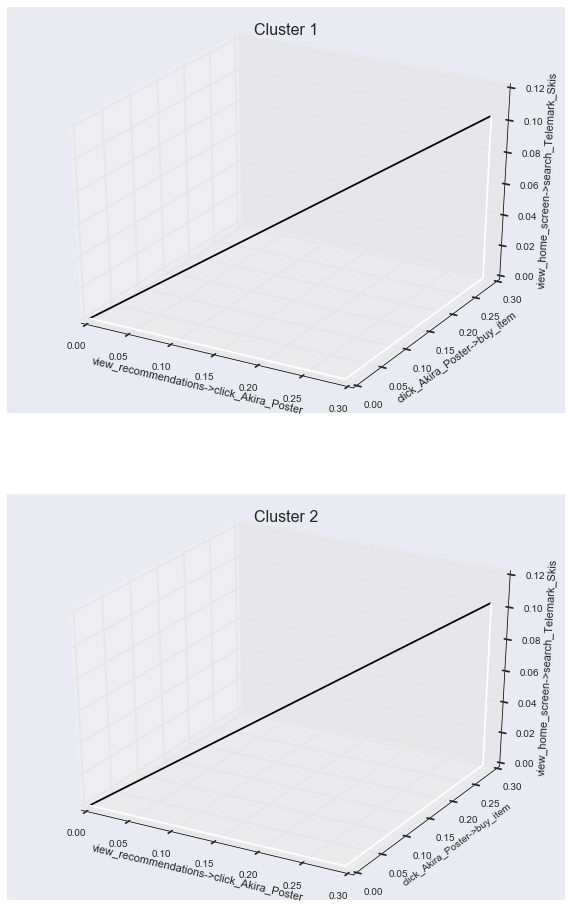

In [15]:
fig = plt.figure(figsize=(10,16))
fig.patch.set_facecolor('white')

ax = fig.add_subplot(211, projection='3d')
ax.set_title('Cluster 1', size = 16)
ax.plot([0,cluster_1_nums[0]], [0,cluster_1_nums[1]], [0,cluster_1_nums[2]], color = 'k')
ax.plot([0,cluster_1_nums[0]], [0,0],[0,0], color = 'white')
ax.plot([cluster_1_nums[0],cluster_1_nums[0]], [0,cluster_1_nums[1]],\
        [0,0], color = 'white')
ax.plot([cluster_1_nums[0],cluster_1_nums[0]], [cluster_1_nums[1],cluster_1_nums[1]],\
        [0,cluster_1_nums[2]], color = 'white')
ax.set_xlabel(cluster_1_names[0], size = 11)
ax.set_ylabel(cluster_1_names[1], size = 11)
ax.set_zlabel(cluster_1_names[2], size = 11)

bx = fig.add_subplot(212, projection = '3d')
bx.set_title('Cluster 2', size = 16)
bx.plot([0, cluster_2_nums[0]], [0, cluster_2_nums[1]], [0, cluster_2_nums[2]], color = 'k')
bx.plot([0, cluster_2_nums[0]], [0,0], [0,0], color = 'white')
bx.plot([cluster_2_nums[0], cluster_2_nums[0]], [0, cluster_2_nums[1]], [0,0], color = 'white')
bx.plot([cluster_2_nums[0], cluster_2_nums[0]], [cluster_2_nums[1], cluster_2_nums[1]],\
       [0, cluster_2_nums[2]], color = 'white')
bx.set_xlabel(cluster_2_names[0], size = 11)
bx.set_ylabel(cluster_2_names[1], size = 10)
bx.set_zlabel(cluster_2_names[2], size = 11)

